## Introduction to Atmospheric Radar Course - Practical 4

<img src="NCAS_national_centre_logo_transparent.png" alt="NCAS" style="width: 200px; horizontal-align:left"/>


## Developing radar processing chains
### Part 2 - Removal of non-meteorological echoes

#### Overview
This notebook introduces a method for removing radar echoes of non-meteorological origin. The method uses the texture of dual-polarisation moments as a descriminator between echo types. While the method is effective in this case, exploring fuzzy-logic or Bayesian classifiers may be more effective for automated data processing. Wradlib contains a fuzzy-logic scheme [(link)](https://docs.wradlib.org/en/stable/notebooks/classify/fuzzy_echo.html) that could be explored in the first instance, otherwise see the course lecture on errors and uncertainty for further reading.


We'll start as usual by importing the python modules we need for this notebook

In [1]:
import pyart
import pyart.graph.cm_colorblind as pycm
import matplotlib.pyplot as plt
import scipy.ndimage as sciim
import numpy as np


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



Then we can load an example file known to contain a variety of non-meteorological echoes, as shown in the lecture and set up a ```RadarMapDisplay``` object for that file, allowing us to plot the coastline which will help give an idea of the source of some of the non-meteorological returns.

In [2]:
radar_file = '/gws/nopw/j04/ncas_radar_vol2/data/ncas-mobile-x-band-radar-1/raine/cfradial/calib_v1/sur/20200507/ncas-mobile-x-band-radar-1_sandwith_20200507-080259_SUR_v1.nc'

radar = pyart.io.read(radar_file)
raddisp = pyart.graph.RadarMapDisplay(radar)

We'll now plot up a multipanel PPI plot of 4 of the variables in the file (see practical 3 for more details on creating multi-panel plots). In addition to reflectivity (dBuZ) we'll also plot the co-polar cross correlation (RhoHV) which we'e seen to be a potentially useful discriminant between meteorological and other echoes, differential reflectivity (ZDR) and the differential phase shift (uPhiDP). 

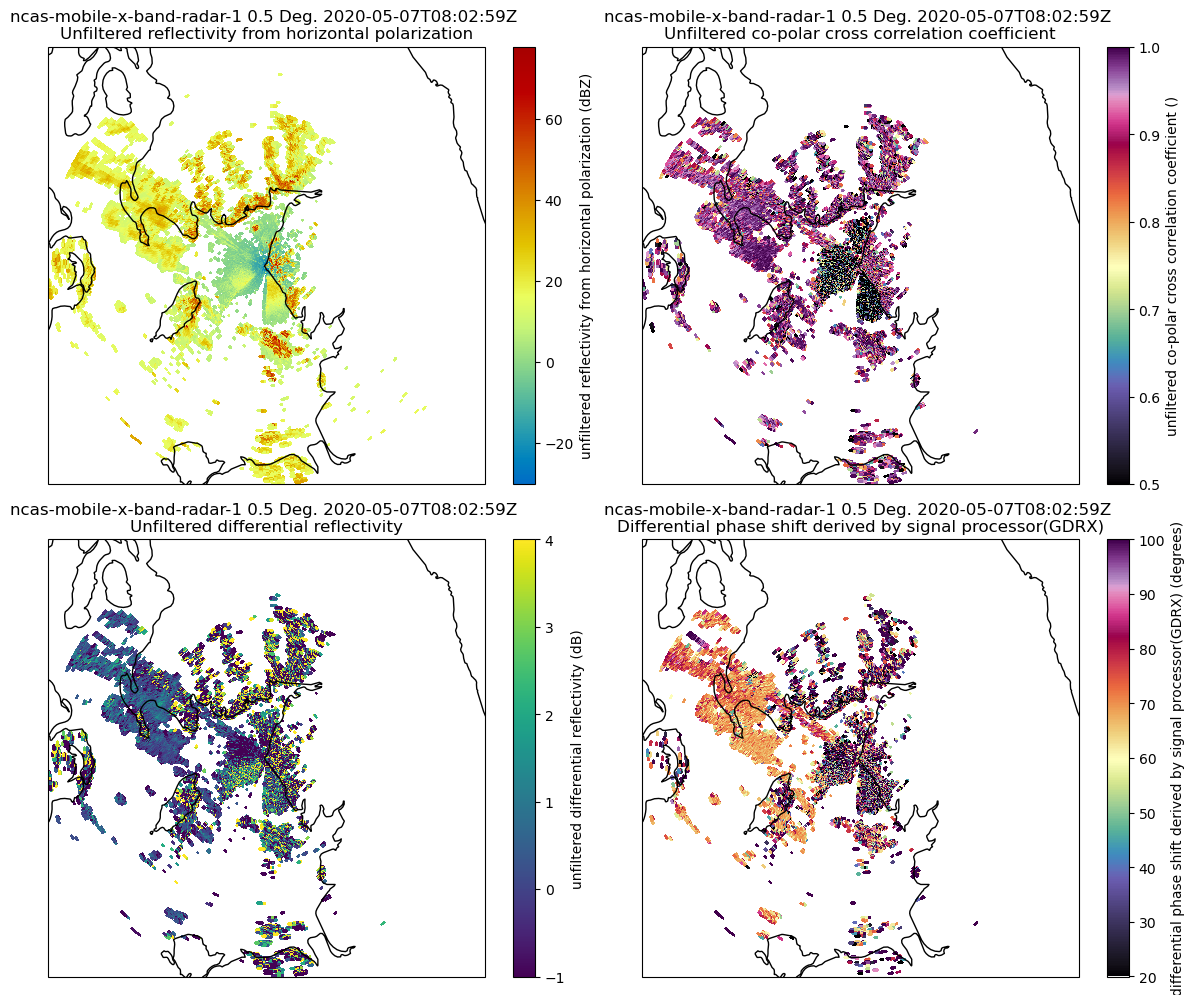

In [3]:
proj = raddisp.grid_projection

fig = plt.figure(figsize=(12,10))

ax1 = plt.subplot(221, projection=proj)
raddisp.plot_ppi_map("dBuZ", 0,
                 cmap=pycm.HomeyerRainbow,
                     embellish=False,
                 ax=ax1)

ax1.coastlines(resolution='10m')

ax2 = plt.subplot(222, projection=proj)
raddisp.plot_ppi_map("RhoHVu", 0,
                 cmap=pycm.ChaseSpectral,
                 vmin=0.5,vmax=1,
                     embellish=False,
                 ax=ax2)

ax2.coastlines(resolution='10m')


ax3 = plt.subplot(223, projection=proj)
raddisp.plot_ppi_map("ZDRu", 0, 
                     vmin=-1, vmax=4,  
                     embellish=False,
                     ax=ax3)

ax3.coastlines(resolution='10m')

ax4 = plt.subplot(224, projection=proj)
raddisp.plot_ppi_map("uPhiDP", 0,
                 cmap=pycm.ChaseSpectral,
                     vmin=20, vmax=100,
                     embellish=False,
                     ax=ax4)

ax4.coastlines(resolution='10m')

plt.tight_layout()

Within the PPIs we can see numerous echoes, some of which are meteorological and some of which aren't. The strongest indicators of non-meteorolgical origin are the very low co-polar correlation coefficient (particularly the sea clutter close to the radar), radially textured differential phase shift, and differential reflectivity.

Bringing in local knowledge of the topography and industry helps identify regions of ground clutter (north-west) and wind turbines (south of the radar, in the sea).

As in part 1 of the practical, we can use gatefilters to remove some of these unwanted (from a hydrometeorological perspective) echoes. We'll start with two fixed thresholds.

In [4]:
gatefilter1 = pyart.filters.GateFilter(radar) # Define a GateFilter object
gatefilter1.exclude_below('SQI',0.4) # Modify the object to now exclude all SQI data below a threshold
gatefilter1.exclude_below('RhoHV',0.9) # Modify the object to now exclude all RhoHV data below a threshold

We can then pass the ```gatefilter1``` object into the "gatefilter" argument within the ```plot_ppi``` function

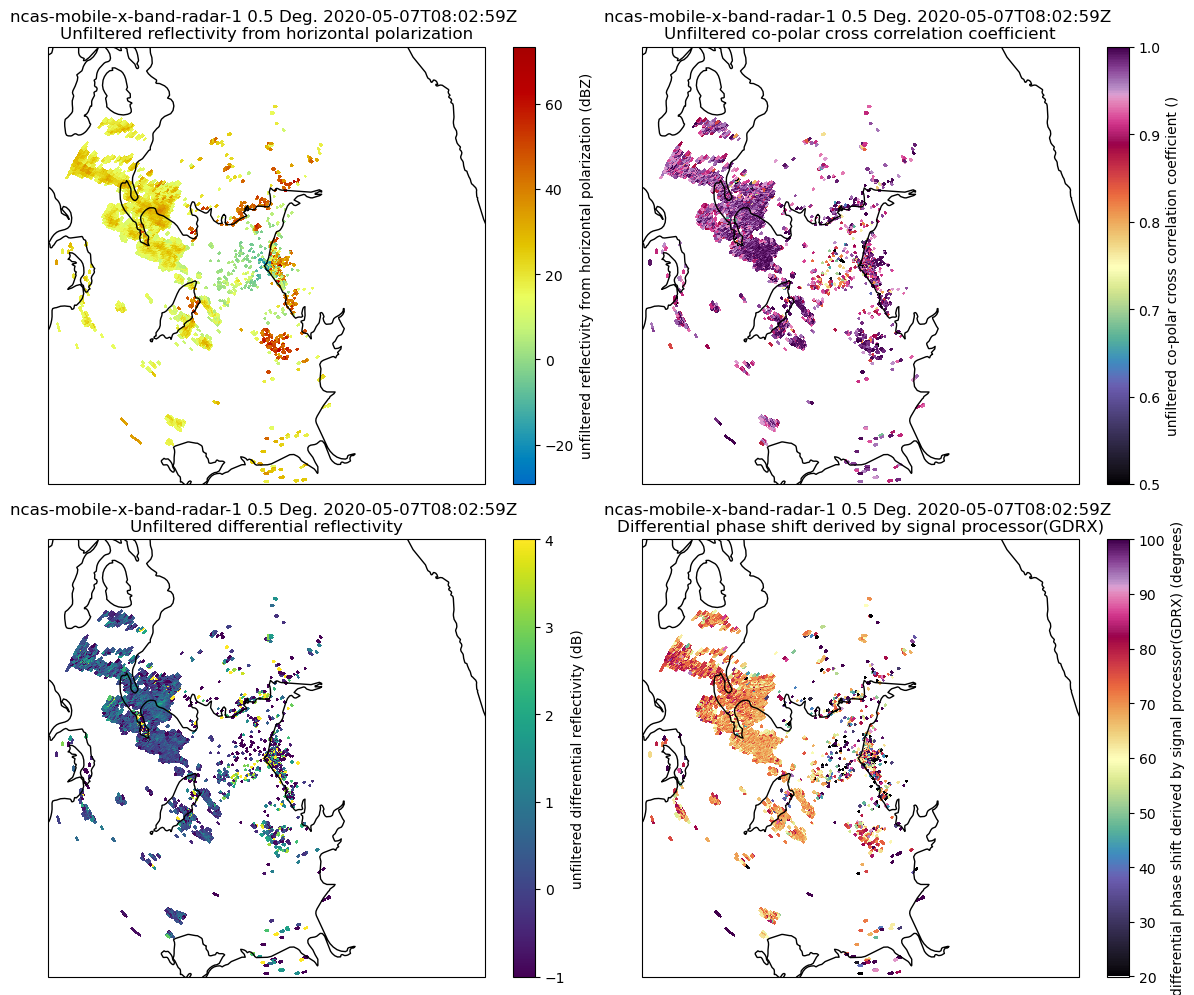

In [5]:
proj = raddisp.grid_projection

fig = plt.figure(figsize=(12,10))

ax1 = plt.subplot(221, projection=proj)
raddisp.plot_ppi_map("dBuZ", 0,
                 cmap=pycm.HomeyerRainbow,
                     embellish=False,
                     gatefilter=gatefilter1,
                 ax=ax1)

ax1.coastlines(resolution='10m')

ax2 = plt.subplot(222, projection=proj)
raddisp.plot_ppi_map("RhoHVu", 0,
                 cmap=pycm.ChaseSpectral,
                 vmin=0.5,vmax=1,
                     embellish=False,
                     gatefilter=gatefilter1,
                 ax=ax2)

ax2.coastlines(resolution='10m')


ax3 = plt.subplot(223, projection=proj)
raddisp.plot_ppi_map("ZDRu", 0, 
                     vmin=-1, vmax=4,  
                     embellish=False,
                     gatefilter=gatefilter1,
                     ax=ax3)

ax3.coastlines(resolution='10m')

ax4 = plt.subplot(224, projection=proj)
raddisp.plot_ppi_map("uPhiDP", 0,
                 cmap=pycm.ChaseSpectral,
                     vmin=20, vmax=100,
                     embellish=False,
                     gatefilter=gatefilter1,
                     ax=ax4)

ax4.coastlines(resolution='10m')

plt.tight_layout()

While this is clearly an improvement, there are a significant number of non-meteorological echoes remaining. We can investigate the texture of the dual-polarisation parameters to consider how these may help. Let's start by contrasting a largely meteorological radial with a cluttered one.

In [6]:
# First find the 1st azimuth in the lowest sweep, this will help us with indexing rays to plot
print(radar.azimuth['data'][0])

175.0122


At around 300 degrees azimuth we can see both precipitation and non-meteorological echoes, while to the south (170 degrees) we can predominantly see sea clutter and wind turbine clutter. We can plot data from both of these azimuths to contrast them.

300.01465
170.01343


Text(0, 0.5, 'Differential phase shift (deg)')

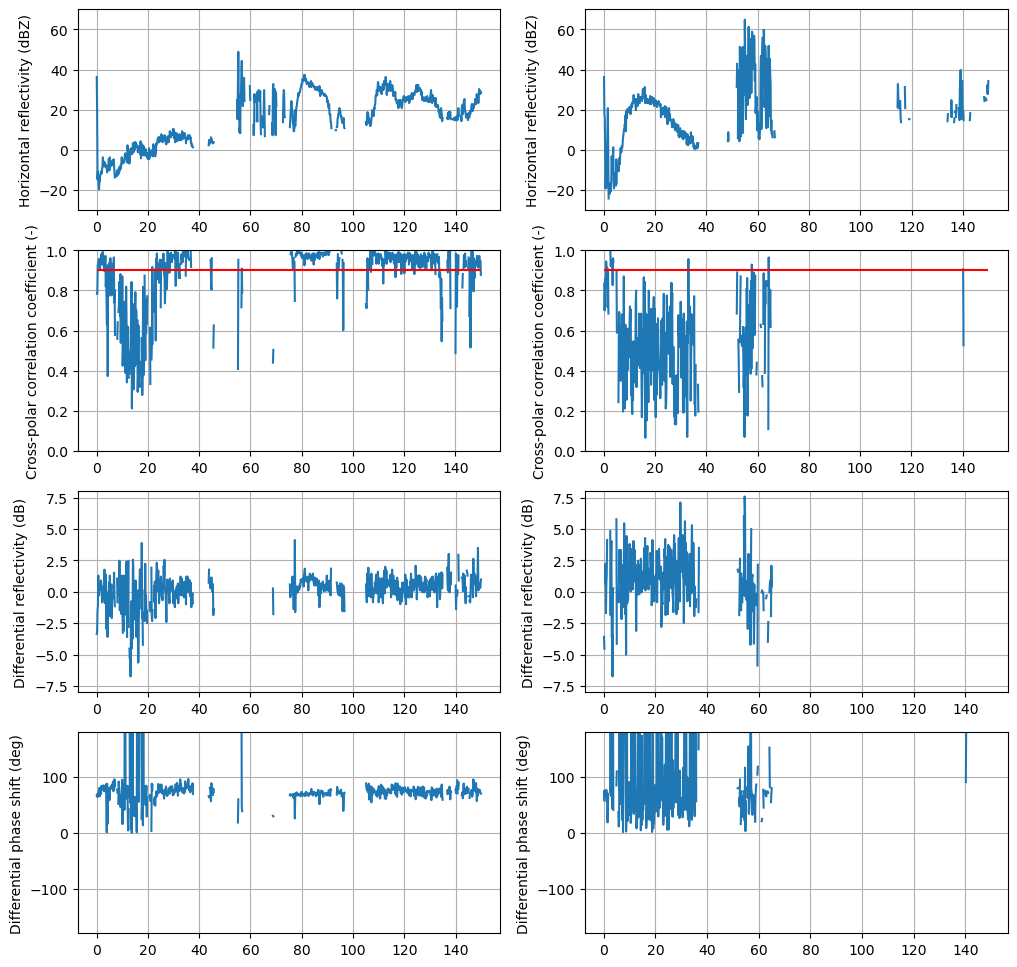

In [7]:
## We'll make one figure for all the ray traces

plt.figure(figsize=(12,12))

# Start with 300 degrees azimuth
ray_index = 125
print(radar.azimuth['data'][ray_index])


plt.subplot(421)

plt.plot(radar.range['data']/1000.0,
         radar.fields['dBuZ']['data'][ray_index])
plt.grid()
plt.ylim(-30,70)
plt.ylabel('Horizontal reflectivity (dBZ)')

plt.subplot(423)
plt.plot(radar.range['data']/1000.0,
         radar.fields['RhoHV']['data'][ray_index])
plt.grid()
plt.hlines(0.9,0,150,color='r')
plt.ylim(0,1)
plt.ylabel('Cross-polar correlation coefficient (-)')

plt.subplot(425)
plt.plot(radar.range['data']/1000.0,
         radar.fields['ZDR']['data'][ray_index])
plt.grid()
plt.ylim(-8,8)
plt.ylabel('Differential reflectivity (dB)')

plt.subplot(427)
plt.plot(radar.range['data']/1000.0,
         radar.fields['uPhiDP']['data'][ray_index])
plt.grid()
plt.ylim(-180,180)
plt.ylabel('Differential phase shift (deg)')

ray_index = 355
print(radar.azimuth['data'][ray_index])

plt.subplot(422)
plt.plot(radar.range['data']/1000.0,
         radar.fields['dBuZ']['data'][ray_index])
plt.grid()
plt.ylim(-30,70)
plt.ylabel('Horizontal reflectivity (dBZ)')

plt.subplot(424)
plt.plot(radar.range['data']/1000.0,
         radar.fields['RhoHV']['data'][ray_index])
plt.grid()
plt.hlines(0.9,0,150,color='r')
plt.ylim(0,1)
plt.ylabel('Cross-polar correlation coefficient (-)')

plt.subplot(426)
plt.plot(radar.range['data']/1000.0,
         radar.fields['ZDR']['data'][ray_index])
plt.grid()
plt.ylim(-8,8)
plt.ylabel('Differential reflectivity (dB)')

plt.subplot(428)
plt.plot(radar.range['data']/1000.0,
         radar.fields['uPhiDP']['data'][ray_index])
plt.grid()
plt.ylim(-180,180)
plt.ylabel('Differential phase shift (deg)')


To make the differential phase shift clearer, we'll unwrap it, so that the values span the range -180 to 180 rather than 0 to 360 and then we can replot the ray traces.

In [8]:
radar.fields['uPhiDP']['data'][:] = np.ma.masked_array(data=np.where(radar.fields['uPhiDP']['data']>180,
                                                                  radar.fields['uPhiDP']['data']-360,
                                                                  radar.fields['uPhiDP']['data']),
                                                    mask=radar.fields['uPhiDP']['data'].mask)

300.01465
170.01343


Text(0, 0.5, 'Differential phase shift (deg)')

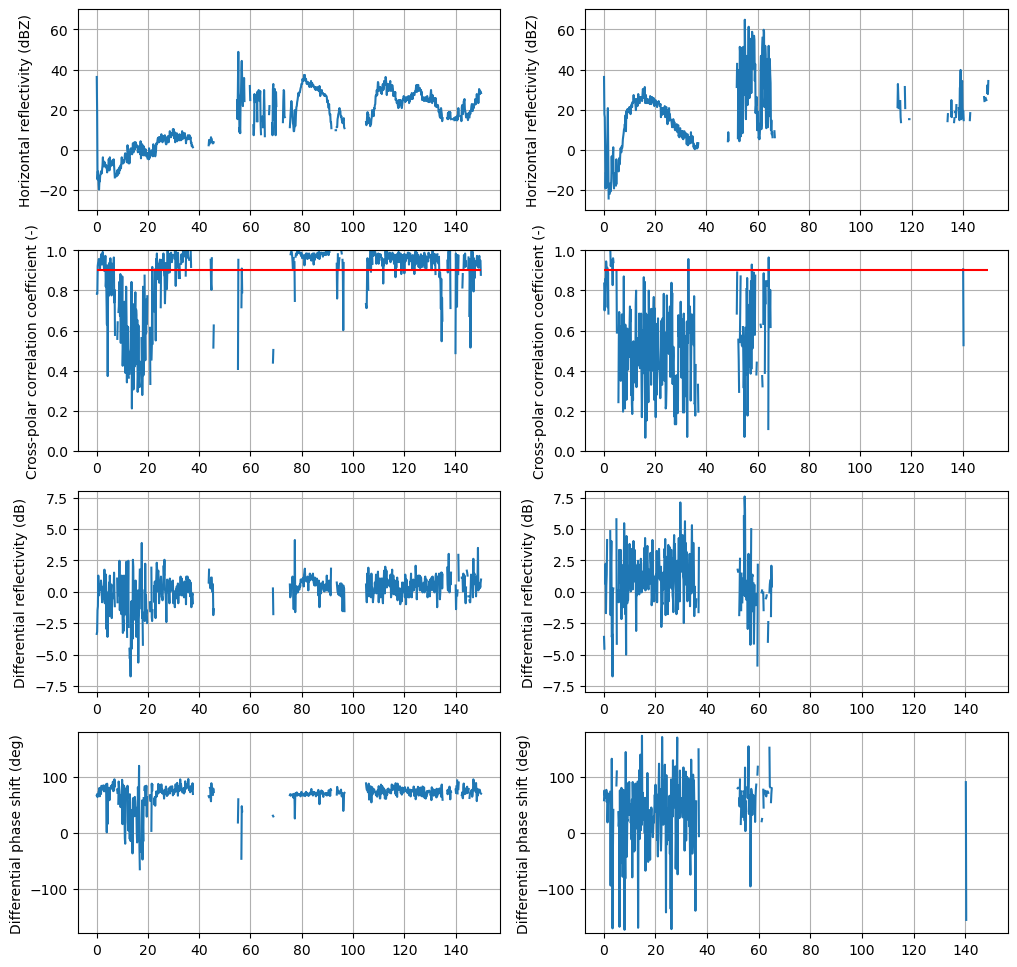

In [9]:
## We'll make one figure for all the ray traces

plt.figure(figsize=(12,12))

# Start with 300 degrees azimuth
ray_index = 125
print(radar.azimuth['data'][ray_index])


plt.subplot(421)

plt.plot(radar.range['data']/1000.0,
         radar.fields['dBuZ']['data'][ray_index])
plt.grid()
plt.ylim(-30,70)
plt.ylabel('Horizontal reflectivity (dBZ)')

plt.subplot(423)
plt.plot(radar.range['data']/1000.0,
         radar.fields['RhoHV']['data'][ray_index])
plt.grid()
plt.hlines(0.9,0,150,color='r')
plt.ylim(0,1)
plt.ylabel('Cross-polar correlation coefficient (-)')

plt.subplot(425)
plt.plot(radar.range['data']/1000.0,
         radar.fields['ZDR']['data'][ray_index])
plt.grid()
plt.ylim(-8,8)
plt.ylabel('Differential reflectivity (dB)')

plt.subplot(427)
plt.plot(radar.range['data']/1000.0,
         radar.fields['uPhiDP']['data'][ray_index])
plt.grid()
plt.ylim(-180,180)
plt.ylabel('Differential phase shift (deg)')

ray_index = 355
print(radar.azimuth['data'][ray_index])

plt.subplot(422)
plt.plot(radar.range['data']/1000.0,
         radar.fields['dBuZ']['data'][ray_index])
plt.grid()
plt.ylim(-30,70)
plt.ylabel('Horizontal reflectivity (dBZ)')

plt.subplot(424)
plt.plot(radar.range['data']/1000.0,
         radar.fields['RhoHV']['data'][ray_index])
plt.grid()
plt.hlines(0.9,0,150,color='r')
plt.ylim(0,1)
plt.ylabel('Cross-polar correlation coefficient (-)')

plt.subplot(426)
plt.plot(radar.range['data']/1000.0,
         radar.fields['ZDR']['data'][ray_index])
plt.grid()
plt.ylim(-8,8)
plt.ylabel('Differential reflectivity (dB)')

plt.subplot(428)
plt.plot(radar.range['data']/1000.0,
         radar.fields['uPhiDP']['data'][ray_index])
plt.grid()
plt.ylim(-180,180)
plt.ylabel('Differential phase shift (deg)')


The clutter regions have significantly more "texture" or variability than the regions after 75km in the 300 degree radial. This is especially apparant in the differential phase shift, but also occurs in the other variabiles. We'll use an inbuilt Py-ART ```pyart.util.texture_along_ray``` function to calculate the texture, but we could calculate a moving standard deviation ourselves. The default length of the texture window is 7 gates in this function but we could vary this if desired.

In [10]:
uPhiDP_texture = pyart.util.texture_along_ray(radar,'uPhiDP')

/home/users/dufton/software/miniconda3/envs/RadarEnv/lib/python3.12/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


Text(0, 0.5, 'Differential phase shift texture (deg)')

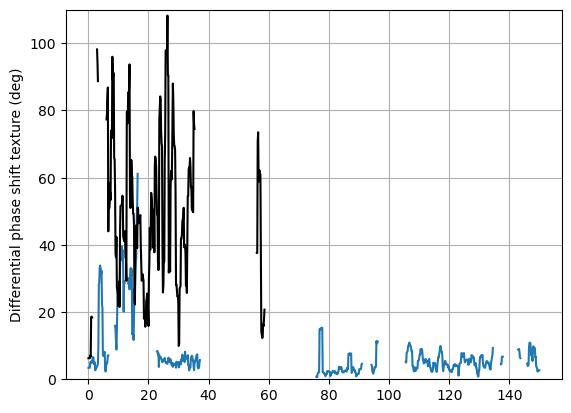

In [11]:
ray_index = 125 # Plot along the 300 degree azimuth again
plt.plot(radar.range['data']/1000.0,
         uPhiDP_texture[ray_index])

ray_index = 355 # Plot along the 170 degree azimuth again, colored black
plt.plot(radar.range['data']/1000.0,
         uPhiDP_texture[ray_index],c='k')


plt.grid()
plt.ylim(0,110)
plt.ylabel('Differential phase shift texture (deg)')


Using the texture of differential phase shift (within a 7 gate window) may allow us to automatically remove more non-meteorological echoes. We could add this new data as a field to the radar object and create a threshold gatefilter using the new field ourselves but PyART also contains a "moment and texture based" gate filter [```pyart.filters.moment_and_texture_based_gate_filter```](https://arm-doe.github.io/pyart/API/generated/pyart.filters.moment_and_texture_based_gate_filter.html). Here we'll use this with it's default options to attempt a more thorough removal of non-meteorological echoes. Note that this function thresholds the radar object using texture of all 4 of the moments we have looked at, along with a threshold on the absolute value of the co-polar correlation coefficient.

In [12]:
gatefilter2 = pyart.filters.GateFilter(radar) # Define a GateFilter object

# Here we have to specify the fields required for the moment and texture based filter. Note SQI is not included.
# We may want to reinclude it after this step.
gatefilter2 = pyart.filters.moment_and_texture_based_gate_filter(radar,
                                                                 zdr_field='ZDR',
                                                                 rhv_field='RhoHV',
                                                                 phi_field='uPhiDP',
                                                                 refl_field='dBuZ',
                                                                 min_rhv=0.9)

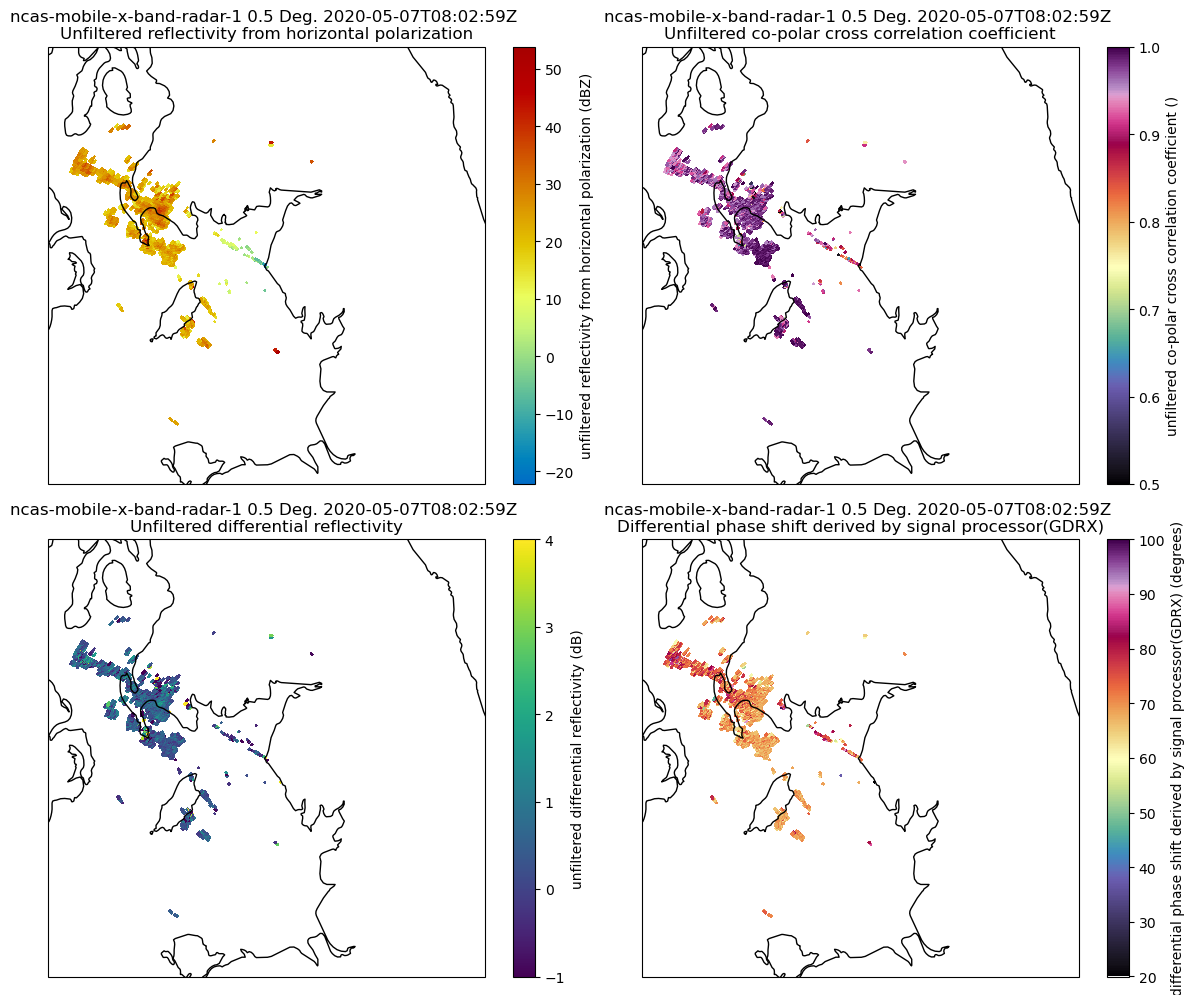

In [13]:
proj = raddisp.grid_projection

fig = plt.figure(figsize=(12,10))

ax1 = plt.subplot(221, projection=proj)
raddisp.plot_ppi_map("dBuZ", 0,
                 cmap=pycm.HomeyerRainbow,
                     embellish=False,
                     gatefilter=gatefilter2,
                 ax=ax1)

ax1.coastlines(resolution='10m')

ax2 = plt.subplot(222, projection=proj)
raddisp.plot_ppi_map("RhoHVu", 0,
                 cmap=pycm.ChaseSpectral,
                 vmin=0.5,vmax=1,
                     embellish=False,
                     gatefilter=gatefilter2,
                 ax=ax2)

ax2.coastlines(resolution='10m')


ax3 = plt.subplot(223, projection=proj)
raddisp.plot_ppi_map("ZDRu", 0, 
                     vmin=-1, vmax=4,  
                     embellish=False,
                     gatefilter=gatefilter2,
                     ax=ax3)

ax3.coastlines(resolution='10m')

ax4 = plt.subplot(224, projection=proj)
raddisp.plot_ppi_map("uPhiDP", 0,
                 cmap=pycm.ChaseSpectral,
                     vmin=20, vmax=100,
                     embellish=False,
                     gatefilter=gatefilter2,
                     ax=ax4)

ax4.coastlines(resolution='10m')

plt.tight_layout()

Note without SQI being included there are still some second trip echoes close to the radar to the north west. We'll add SQI back in and add a speckle filter as we did in part 1.

In [14]:
gatefilter3 = pyart.filters.GateFilter(radar) # Define a GateFilter object

# Here we have to specify the fields required for the moment and texture based filter.
gatefilter3 = pyart.filters.moment_and_texture_based_gate_filter(radar,
                                                                 zdr_field='ZDR',
                                                                 rhv_field='RhoHV',
                                                                 phi_field='uPhiDP',
                                                                 refl_field='dBuZ',
                                                                 min_rhv=0.9)
gatefilter3.exclude_below('SQI',0.4)
gatefilter3 = pyart.correct.despeckle_field(radar,'dBuZ',gatefilter=gatefilter3)

/home/users/dufton/software/miniconda3/envs/RadarEnv/lib/python3.12/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


We can now contrast the orginal reflectivity observations with the gatefiltered observations using a two panel plot.  

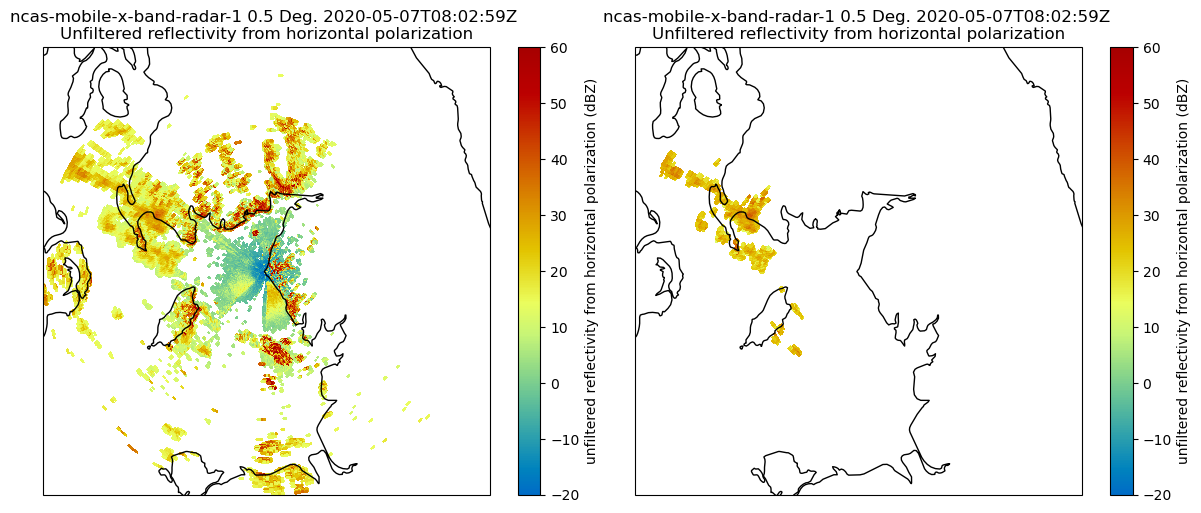

In [20]:
proj = raddisp.grid_projection

fig = plt.figure(figsize=(12,5))

ax1 = plt.subplot(121, projection=proj)
raddisp.plot_ppi_map("dBuZ", 0,
                 cmap=pycm.HomeyerRainbow,
                     embellish=False,
                     vmin=-20,vmax=60,
                 ax=ax1)

ax1.coastlines(resolution='10m')

ax2 = plt.subplot(122, projection=proj)
raddisp.plot_ppi_map("dBuZ", 0,
                 cmap=pycm.HomeyerRainbow,
                     embellish=False,
                     vmin=-20,vmax=60,
                     gatefilter=gatefilter3,
                 ax=ax2)

ax2.coastlines(resolution='10m')

plt.tight_layout()

The moment and texture based gatefitler appears to have removed all the clutter within the PPI. However, it has also removed lower intensity meteorological echoes in the north west. This aggressive level of filtering may be approprate depending on the use case of the data but you might like to play with the threshold levels within the gatefilter to see if you can retain more of these echoes. One factor in this removal is the natural increase in the texture of meteorological echoes with increasing range and lower signal-to-noise ratio.

#### Next steps:

Now we'll spend some time applying gatefilters to our own case studies. How much data can we retain while filtering out unwanted echoes? Are there any downsides to applying default gatefilters in this way?

Then we'll cover attenuation and QPE in two further follow along notebooks, practical 4 part 3 and part 4.